## 랜덤 포레스트
### 랜덤 포레스트의 개요 및 실습
- 같은 알고리즘으로 여러 개의 분류기를 만들어서 보팅으로 최종 결정하는 알고리즘.
- 부트스트래핑 (bootstrapping) 분할 방식 : 전체 데이터에서 일부가 중첩되게 샘플링된 데이터 세트

In [1]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data = old_feature_name_df.groupby('column_name').cumcount(), columns = ['dub_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how = 'outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dub_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) if x[1] > 0 else x[0], axis = 1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis = 1)
    return new_feature_name_df

In [2]:
import pandas as pd

def get_human_dataset():
    feature_name_df = pd.read_csv('features.txt', sep = '\s+', header = None, names = ['column_index', 'column_name'])

    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame 생성.
    new_feature_name_df = get_new_feature_name_df(feature_name_df)

    # DataFrame에 피처명을 칼럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()

    # 학습 피처 데이터 세트와 테스트 피처 데이터를 DataFrame으로 로딩. 칼럼명은 feature_name으로 적용
    X_train = pd.read_csv('X_train.txt', sep = '\s+', names = feature_name)
    X_test = pd.read_csv('X_test.txt', sep = '\s+', names = feature_name)

    # 학습 레이블과 테스트 레이블 데이터를 DataFrame으로 로딩하고 칼럼명은 action으로 부여
    y_train = pd.read_csv('y_train.txt', sep = '\s+', header = None, names = ['action'])
    y_test = pd.read_csv('y_test.txt', sep = '\s+', header = None, names = ['action'])

    # 로드된 학습 / 테스트용 DataFrame을 모두 반환
    return X_train, X_test, y_train, y_test


In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

# 결정 트리에서 사용한 get_human_datget_human_dataset()을 이용해 학습/테스트용 DataFrame 반환
X_train, X_test, y_train, y_test = get_human_dataset()

# 랜덤 포레스트 학습 및 별도의 테스트 세트로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0, max_depth=8)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('랜덤 포레스트 정확도 : {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도 : 0.9196


### 랜덤 포레스트 하이퍼 파라미터 및 튜닝

In [4]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth' : [8, 16, 24],
    'min_samples_leaf' : [1, 6, 12],
    'min_samples_split' : [2, 8, 16]
}

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 2, n_jobs = -1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터 : \n', grid_cv.best_params_)
print('최고 예측 정확도 : {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터 : 
 {'max_depth': 16, 'min_samples_leaf': 6, 'min_samples_split': 2}
최고 예측 정확도 : 0.9165


In [5]:
rf_clf1 = RandomForestClassifier(n_estimators=100, min_samples_split=2, min_samples_leaf=6, max_depth=16, random_state=0)
rf_clf1.fit(X_train, y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도 : {0:.4f}'.format(accuracy_score(y_test, pred)))

예측 정확도 : 0.9260


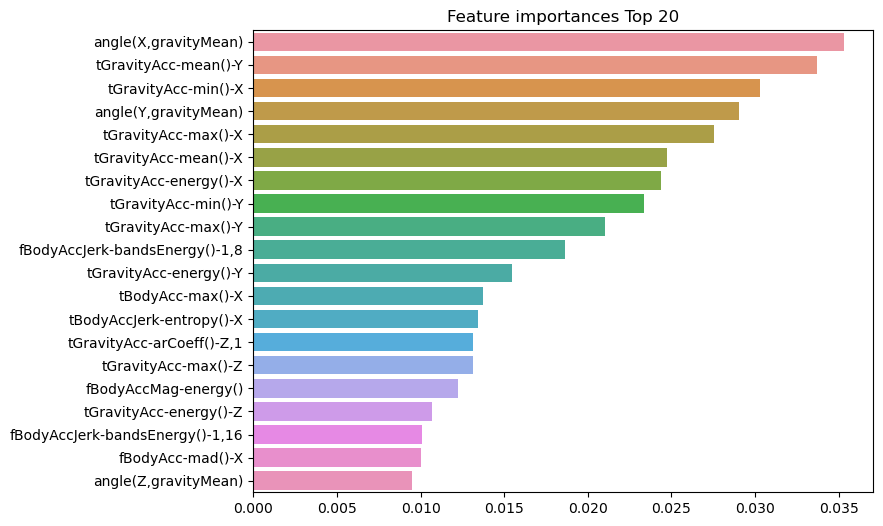

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize = (8, 6))
plt.title('Feature importances Top 20')
sns.barplot(x = ftr_top20, y = ftr_top20.index)
plt.show()